# Learning Goals

The goal of this assignment is to develop an understanding of how the brain performs computations at the neuronal level. To do so, you will develop several models of a spiking neuron. By the end of this assignment, you should a) be comfortable with developing models of spiking neurons at different levels of abstraction, from the biologically plausible H-H model to the phenomenological LIF model; b) understand how neurons use their firing rate to represent continuous-valued information; and c) understand the trade-offs involved in spike-based information representation. 

Let's first import all the libraries required for this assignment

In [148]:
import math
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

# Question 1: The Hodgkin Huxley Neuron
## 1a. 
We will start by implementing the different computational models of a spiking neuron, with the aim of understanding the differences between the different models. We will start with one of the earliest, yet one of the most biologically faithful models of a neuron - The Hodgkin-Huxley (HH) model. Below is the class definition of an HH neuron. Your first task is to fill the different components required to simulate an HH neuron. 

In [251]:
class HodgkinHuxley():
    """Implementation of Hodgkin Huxley Model"""
    def __init__(self, C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, T, dt):
        """
        :param C_m: membrane capacitance in uF/cm^2
        :param g_Na: Sodium conductance in mS/cm^2
        :param g_K: Potassium conductance in ms/cm^2
        :param g_L: Leak maximum conductance
        :param E_Na: Sodium Nernst reversal potential in mV
        :param E_K: Potassium Nernst reversal potential in mV
        :param E_L: Leak Nernst reversal potential in mV
        :param T: Simulation timesteps
        :param dt: Integration time 
        
        This function is complete. You do not need to do anything here.
        """
        self.C_m = C_m 
        self.g_Na = g_Na 
        self.g_K = g_K
        self.g_L = g_L
        self.E_Na = E_Na
        self.E_K = E_K
        self.E_L = E_L
        self.T = T
        self.dt = dt
        self.t = np.arange(0, self.T, self.dt) #time to integrate over
    
    def alpha_m(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: alpha_m
        
        Fill in the equation for alpha_m
        """
        alpha_m = 0.1 * (V+40)/(1-np.exp(-(V+40)/10))
        
        return alpha_m
    
    def beta_m(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: beta_m
        
        Fill in the equation for beta_m
        """
        beta_m = 4*np.exp(-(V+65)/18)
        
        return beta_m
    
    def alpha_h(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: alpha_h
        
        Fill in the equation for alpha_h
        """
        alpha_h = 0.07*(np.exp(-(V+65)/20))
        return alpha_h
    
    def beta_h(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: beta_h
        
        Fill in the equation for beta_h
        """
        beta_h = 1/(1+np.exp(-(V+35)/10))
        return beta_h
    
    def alpha_n(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: alpha_n
        
        Fill in the equation for alpha_n
        """
        alpha_n = 0.01*(55+V)/(1-np.exp(-(V+55)/10))
        return alpha_n
    
    def beta_n(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: beta_n
        
        Fill in the equation for beta_n
        """
        beta_n = 0.125*np.exp(-(V+65)/80)
        return beta_n
    
    def I_Na(self, V, m, h):
        """
        Membrane Sodium current
        :param V: membrane voltage
        :param m: gating variable m
        :param h: gating variable h
        :return: sodium current I_Na
        
        Fill in the equation for I_Na
        """
        I_Na = math.pow(m,3) * self.g_Na * h * (V - self.E_Na)
        return I_Na 
    
    def I_K(self, V, n):
        """
        Membrane Potassium current
        :param V: membrane voltage
        :param h: gating variable h
        :return: Potassium current I_K
        
        Fill in the equation for I_K
        """
        
        I_k = math.pow(n,4) * self.g_K * (V - self.E_K)
        return I_k
    
    def I_L(self, V):
        """
        Membrane Leak current
        :param V: membrane voltage
        :return: Leak current I_L
        
        Fill in the equation for I_L
        """
        I_L = self.g_L *(V - self.E_L)
        return I_L

    def I_inj(self, t):
        """
        External current
        :param t: time
        :return: step up to 10 uA/cm^2 at t>100
                step down to 0 uA/cm^2 at t>200
                step up to 35 uA/cm^2 at t>300
                step down to 0 uA/cm^2 at t>400
        
        This function is complete. You do not need to do anything here.
        """
        return 10*(t>100) - 10*(t>200) + 35*(t>300) - 35*(t>400)
    
    @staticmethod
    def computeDerivatives(X, t, self):
        """
        Function to integrate membrane potential and activation variables
        :param X: array containing the integration variables: V, m, h, n
        :param t: time
        :return dVdt: increment in membrane voltage
                dmdt: increment in m
                dhdt: increment in h
                dndt: increment in n
        
        Fill in the update equations for dVdt, dmdt, dhdt, dndt
        """
        V, m, h, n = X #unwrap X into the membrane potential and activation variables
        dVdt =  (1/self.C_m) * (self.I_inj(t) - (self.I_Na(V,m,h) + self.I_K(V,n) + self.I_L(V)))#compute increment in membrane voltage
        dmdt =  self.alpha_m(V)*(1-m)-self.beta_m(V)*m #compute increment in m
        dhdt =  self.alpha_h(V)*(1-h)-self.beta_h(V)*h #compute increment in h
        dndt =  self.alpha_n(V)*(1-n)-self.beta_n(V)*n#compute increment in n
        return dVdt, dmdt, dhdt, dndt
    
    def run(self):
        """
        Main function to simulate HH neuron and plot voltage and current against time. This part is complete. DO NOT change this code. You do not need to fill anything here. 
        """
        X = odeint(self.computeDerivatives, [-65, 0.05, 0.6, 0.32], self.t, args=(self,))
        V, m, n, h = X[:, 0], X[:, 1], X[:, 2], X[:, 3]
        plt.figure()
        plt.subplot(2,1,1)
        plt.title('Hodgkin-Huxley Neuron')
        plt.plot(self.t, V, 'k')
        plt.ylabel('V')
        
        plt.figure()
        plt.subplot(2,1,2)
        i_inj = [self.I_inj(t) for t in self.t]
        plt.plot(self.t, i_inj, 'k')
        plt.xlabel('t')
        plt.ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
        plt.ylim(-1, 40)
        
        plt.show()

## 1b. 
Initialize an HH neuron using a proper set of parameters; then run the simulation. You should be able to get a plot depicting how the Voltage and Current of the neuron change with time. 

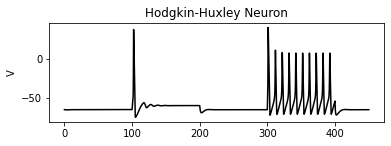

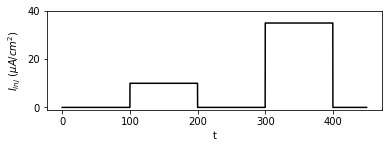

In [252]:
#1. Initialize an hh neuron using the class definition above
# hh = HodgkinHuxley(1.0, 120.0, 36.0, 0.3, 115, -12.0, 10.6, 450.0, 0.01)
hh = HodgkinHuxley(1.0, 100.0, 36.0, 0.3, 50, -77.0, -54.387, 450.0, 0.01)
hh.run()
#2. Run the hh neuron simulation

## 1c. 
The beauty of a neurophysiologically accurate model of a neuron is that it allows the simulation of several phenomena that can take place in the brain. Assume that you administer a drug named Tetrodotoxin (TTX), which is a potent neurotoxin that inhibits the voltage-gated sodium channels, and therefore decreases the sodium current. Simulate the effects that administering TTX would have on the neural firing.  Do the same for another drug, pronase,
which eliminates sodium inactivation. 

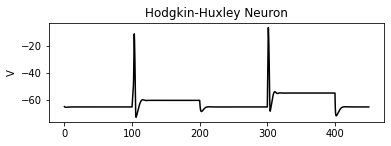

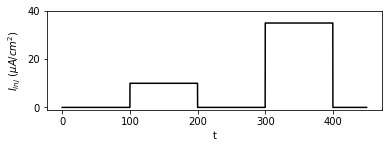

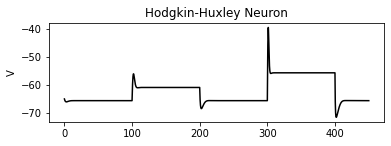

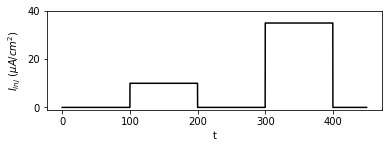

In [253]:
#1. Initialize an hh neuron to simulate TTX

#2. Run the hh neuron simulation
hh = HodgkinHuxley(1.0, 100, 36, 0.3, 0, -77, -53.22, 450, 0.01)
hh.run()

#3. Initialize an hh neuron to simulate pronase

#4. Run the hh neuron simulation
hh = HodgkinHuxley(1.0, 0, 36, 0.3, 50, -77, -53.22, 450, 0.01)
hh.run()

# Question 2: The Izhikevich Neuron

## 2a.
We will now implement an Izhikevich (Izhi) neuron model. Below is the class definition of an Izhi neuron. Like before, your task is to fill in the different components required to simulate an Izhi neuron. You should notice one key difference in the implementation: While our HH implementation relied on the odeint libary from scipy for integration, here we will use 'Euler's method' to integrate. The Euler's method is very intuitive, simple, and can be easily implemented. For your reference, the dynamics of an Izhi neuron are described in equations 1, 2, 3 in the paper: https://www.izhikevich.org/publications/spikes.pdf

In [254]:
class Izhi():
    """Implementation of the Izhikevich neuron Model"""
    def __init__(self, a, b, c, d, Vth, T, dt):
        """
        :param a, b, c, d: Izhi neuron parameters
        :param Vth: Voltage threshold for spiking
        :param T: Simulation timesteps
        :param dt: Integration time 
        
        This function is complete. You do not need to do anything here.
        """
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.Vth = Vth
        self.u = self.b * self.c #initialize u
        self.T = T
        self.dt = dt
        self.t = np.arange(0, self.T, self.dt)
        self.I = 10 #Input stimulus current
        
    def run(self):
        """
        Main function to simulate Izhi neuron and plot voltage and current against time. Fill in the update equations for du, dv, v[t] and u[t] and resetting on spiking.
        """
        V = np.zeros(len(self.t)) #Initialize a numpy array containing the membrane voltages for all the timesteps
        V[0] = self.c #Initial membrane voltage is the rest potential, defined by the parameter 'c'
        u = np.zeros(len(self.t)) #Initialize a numpy array containing u for all the timesteps
        u[0] = self.u #Initial u
        
        for t in range(1, len(self.t)): #the time loop for performing euler's integration
            dv = (0.04 * V[t-1] + 5) * V[t-1] + 140 - u[t-1] #compute increment in voltage
            du =   self.a * (self.b * V[t-1] - u[t-1]) #compute increment in u
            V[t] =  V[t-1] + (dv + self.I) * self.dt #update the voltage
            u[t] =  u[t-1] + self.dt * du #update u
            
            #condition for when membrane potential is greater than the threshold
            if V[t] >= self.Vth:
                V[t] =  self.c #reset v
                u[t] =  u[t-1] + self.d  #reset u
                
        #plotting
        """This function is complete. You do not need to do anything here"""
        plt.figure()
        plt.subplot(2,1,1)
        plt.title('Izhi Neuron')
        plt.plot(self.t, V, 'k')
        plt.ylabel('V')
        
        plt.figure()
        plt.subplot(2,1,2)
        i_inj = [self.I for t in self.t]
        plt.plot(self.t, i_inj, 'k')
        plt.xlabel('t')
        plt.ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
        
        plt.show()

## 2b. 
Initialize an Izhi neuron with the correct parameters and run the simulation. You should again be able to get a plot depicting how the Voltage and Current of the neuron change with time. 

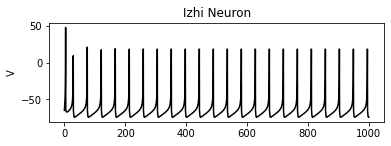

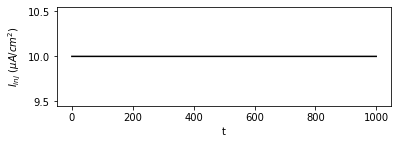

In [255]:
#1. Initialize an izhikevich neuron with the appropriate parameters
Iz = Izhi(0.02, 0.2, -65, 8, 65, 1000, 0.5)
#2. Run the simulation and obtain the results
Iz.run()


## 2c.
Change the parameters of the Izhi neuron in the code to replicate two different patterns identified in neurons, e.g., bursting and adaptation. You can find the parameters for several different Izhi models here: https://www.izhikevich.org/publications/spikes.pdf

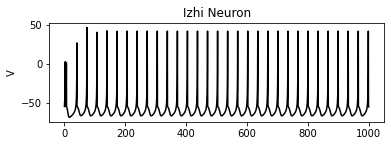

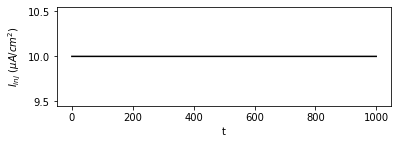

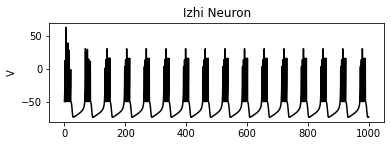

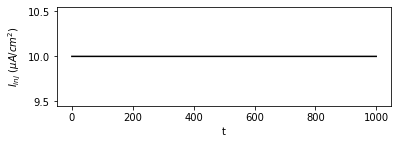

In [7]:
#Write your implementation of the bursting and chattering neuron here

#1. Initialize an izhikevich neuron with the appropriate parameters

#2. Run the simulation and obtain the results
Iz = Izhi(0.02, 0.2, -55, 4, 65, 1000, 0.5)
Iz.run()

Iz = Izhi(0.02, 0.2, -50, 2, 65, 1000, 0.5)
Iz.run()


# Question 3: The LIF Neuron

## 3a. 
In this question, you will implement the almighty leaky integrate and fire neuron (LIF). The LIF neuron is the most widely-used model of a neuron in the SNN literature and you will be using it a lot for your course assignments and for your project. Below is the class definition of an LIF neuron. Just like the Izhi neuron, we will use Euler's method to perform integration. There is one key difference however: For HH and Izhi implementations, the neuron was taking current as the input. In our LIF implementation, the neuron takes spike-trains as inputs and produces spike-trains as output, similarly to how a real neuron works. 

As a hint, we provide here a discrete-time version of an LIF neuron:

* First, integrate the input spikes into current with some decay factor

$$C[t] = C[t-1] * current\_decay + input\_spike[t]$$

* Then, integrate the current  into voltage with some decay factor

$$V[t] = V[t-1] * voltage\_decay + C[t]$$

* Lastly produce a spike if the voltage exceeds the threshold, and reset voltage

$$if V[t] >= Vth  \\ output\_spike[t] = 1 \ and \ V[t] = Rest\_Potential $$

In [256]:
class LIF():
    """Implementation of Leaky integrate and fire neuron Model"""
    def __init__(self, dc, dv, Vth, Vr):
        """
        :param dc: Decay factor for current
        :param dv: Decay factor for voltage
        :param Vth: Voltage Threshold
        :param Vr: Rest potential 
        
        This function is complete. You do not need to do anything here
        """
        self.dc = dc
        self.dv = dv
        self.Vth = Vth
        self.Vr = Vr
    
    def run(self, in_spikes):
        """
        Main function to simulate LIF neuron
        :param in_spikes: Input spike train
        :return out_spikes: output spike train
        
        Fill in the parts for updating Cm, Vm, and the condition for spiking and resetting
        """
        Vm, Cm, out_spikes = [np.zeros(len(in_spikes)) for l in range(3)] #initialize the state variables
        for t in range(1, len(in_spikes)): #Time loop to perform Euler's Integration
            Cm[t] =  Cm[t-1]*self.dc+in_spikes[t]#Integrate input spikes into current
            Vm[t] =  Vm[t-1]*self.dv+Cm[t]#Integrate current into voltage
            
            #condition for when membrane potential is greater than the threshold
            if Vm[t]>=self.Vth:
                out_spikes[t]=1
                Vm[t]=self.Vr
        
        return out_spikes

## 3b. 
Based on the class definition above, create an LIF neuron with the following parameters: dc = 0.5, dv = 0.5, Vth = 0.50, Vr = 0. 
Then apply to the neuron a random spike train for 15 timesteps. You might find the following numpy package useful to generate the input spike train:
https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

Simulate the neuron and print input and output spikes. 

In [257]:
#1. Create an LIF neuron with the required parameters using the class definition above
lx = LIF(0.5,0.5,0.50,0)

#2. Generate a random input spike train of 15 timesteps using the numpy random choice library function
inp_spike= np.random.choice([0,1],15)
#3. Print the input spikes
print(inp_spike)
#4. Stimulate the LIF neuron with input spikes and return the output spikes
output_spikes = lx.run(inp_spike)
print(output_spikes)
#5. Print the output spikes

[1 1 1 0 0 1 0 0 1 1 0 1 1 0 1]
[0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]


# Question 4: Biology vs. Efficiency
Now that you have simulated spiking neuron models at different levels of abstraction, we will learn how to differentiate between the three neuron models that we have developed, based on the following criteria:
* Biological realism
* Computational Efficiency

Can you describe for what tasks might you need an HH model? For what tasks would an LIF neuron be a better alternative?
*Hint*: Why one should use a neuron model that replicates several of the neuron's mechanisms vs. using a model that emulates the neuron as a spike-in-spike-out black box. 

## Answer 4:
HH model contains 7 equations with 26 parameters in all, most of the parameters define the kinetic properties of the voltage-gated sodium and potassium conductances. From this itself, we can note that Hodgkin Huxley is a purely electrical model. It makes no reference to biochemistry, changes to cytoplasmic ionic concentrations, or other intracellular processes. In HH model, the Na current corresponds to something that can be physically measured, but the Na gating variable (m) has no biophysical counterpart in the actual protein. HH model has high empirical content. Empirical content only refers to the logical structure of the models, that is, the kind of predictions they can make, but it does not address the question of whether these predictions are accurate or not. HH model neurons are very accurate  but we can only simulate a handful of these neurons since it’s so computationally expensive.

Unlike the Hodgkin-Huxley model, the Izhikevich model does not account for the biophysics of neurons. It uses mathematical equations to compute a wide range of spiking patterns for cortical neurons. The output is incredibly realistic and biologically plausible. This model is also computationally feasible.

Leaky integrate-and-fire model does not perform well at predicting the spike times of a real neuron;  However, if adaptation (and refractoriness) is added to the neuron model, the prediction works well. So it is computationally efficient but not biologically realistic.


# Question 5: Tuning Membrane Properties of the LIF neuron
## 5a.
In this question, you will understand how to tune the membrane properties of an LIF neuron. First, generate 20 inputs in the form of random spike trains of length 50, i.e. 50 timesteps. The inputs will have different levels of probabilities for spike generation, that ranges between 0.1 and 1.0 with step size of 0.05. In other words, you will create 20 spike trains with the first spike train having the probability of 0.1 to generate spikes at any timestep, the second spike train will have the spike generation probability of 0.15, and so on. 

Simulate an LIF neuron with the parameters defined in Question 3b. You will now drive the neuron model with the 20 randomly generated input spike trains that you have created, and compute the output spike train. 
At the same time, compute the input firing rate and output firing rate for each simulation. Firing rate is defined as the mean of the spike train, i.e. total number of spikes/timesteps

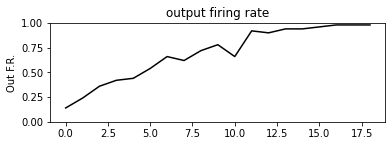

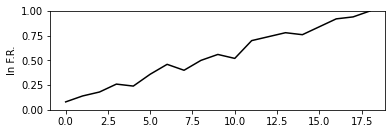

In [259]:
def lif_behavior(lif):
    """Function to understand the behavior of LIF neuron for different densities of spike inputs
    :param lif: An instance of the LIF neuron
    """
    #1. Create lists to store the input and output firing rates
    in_fr = [] #input firing rate
    out_fr = [] #output firing rate
    
    #2. Create a list of probabilities: from 0.1 to 1.0 with step size of 0.05. You might find the numpy arange function helpful here.
    probabilities = np.round(np.arange(0.1,1.05,0.05),2)
    
    #3. Loop through the range of probabilities
    for p in probabilities:
        in_spikes = np.random.choice([0,1],p=[1-p,p],size=50) #sample input spikes using np.random.choice function
        
        #compute input firing rate and append to the in_fr list
        total_in_spikes = sum(in_spikes)
        
        in_fr.append(total_in_spikes/50)
        
        #obtain output spikes by applying the input to the LIF neuron
        output_spikes = lx.run(in_spikes)
        
        #compute output firing rate and append to the out_fr list
        total_output_spikes = sum(output_spikes)
                                 
        out_fr.append(total_output_spikes/50)

    #Plot the input and output firing rates. Nothing to do here. This part is complete
    plt.figure()
    plt.subplot(2,1,1)
    plt.title('output firing rate')
    plt.plot(out_fr, 'k')
    plt.ylabel('Out F.R.')
    plt.ylim([0,1])

    plt.figure()
    plt.subplot(2,1,2)
    plt.plot(in_fr, 'k')
    plt.ylabel('In F.R.')
    plt.ylim([0,1])
    plt.show()

#Run the lif behavior function for the LIF neuron that we created previously
lif = LIF(0.5,0.5,0.5,0)
lif_behavior(lif)

## 5b. 
Describe how soon does the output firing rate start to saturate? Can you describe why this could be problematic? *Hint: Think from the point of view of distinguishing between two different inputs based on firing activity*

## Answer 5b.
The output firing rate starts to saturate at a range of 12-15 itself, this is mainly because of the current decay being higher causing the saturation to arrive way earlier.
If we had to distinguish two different input spikes on the basis of firing rate, it could be done on the basis of reducing the current decay.

## 5c. 
Change the membrane properties of the LIF neuron to resolve the issue of saturation. In other words, experiment on setting different parameter values that do not allow the output firing rate to saturate so early. *Hint: You may want to start by changing one variable at a time, and see its effect. Try to move it slightly, or abruptly, up or down. Then move to the next parameter, until you see what is its effect on the neuron's output.* 

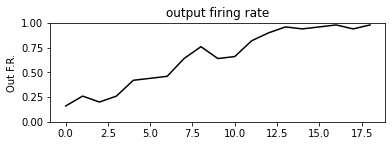

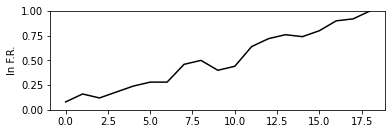

In [245]:
#1. Create an LIF neuron with appropriately tuned membrane properties

#2. Call the lif behavior function on the tuned lif neuron
lif = LIF(0.2,0.5,0.5,0)
lif_behavior(lif)

## 5d.
Based on the above results, can you describe how changing the H-H parameters changes the voltage threshold of a spiking neuron as a function of the input spikes?

## Answer 5d.
On the basis of changing the current decay, we can observe that the saturation doesn't arrive early. This causes lesser affect on the voltage threshold of a spiking neuron.

# Question 6: Encoding continuous inputs into spikes
## 6a.
Now we will understand how we can represent continuous-valued inputs as spikes so that drive our spiking neuron. Describe two prominent ways to encode a continuous-valued input into the spiking activity of a neuron. 

## Answer 6a.
Two prominent ways to represent continuous valued inputs as spikes is via Rate coding and Temporal coding.
Rate coding is used to compare differences in spiking from different stimuli. It is measuring the number of spikes that occur during a set period of time. It deals with the neuron fires spikes with a rate that is monotonically related to the intensity of that feature. This model works well with changes that vary slowly in time, because the noisiness of the spikes requires integration over some time window.
On the other hand Temporal code refers to information about the action contained in the relative timing of the spike. There are multiple types of temporal coding available for different interpretations of relative timing.


## 6b. 
So far we have learned how we can stimulate a spiking neuron using spike inputs. In this exercise, you will learn how to encode real-world data into spikes that can then be fed as inputs to the spiking neuron. We will take a digit from the popular MNIST dataset as an example. First let's see what a sample digit from the MNIST image looks like. For this, we need to create a loader for the MNIST dataset using a Pytorch function called datasets.MNIST. You do not need to know what a loader is for now. Just understand the two important arguments of the function: The first argument is the directory where the MNIST dataset will be downloaded. The third argument is the set download option. This should be true for the first time when you run this cell to allow you to download the MNIST data into your directory. You can set it to false if the MNIST data has already been downloaded. 

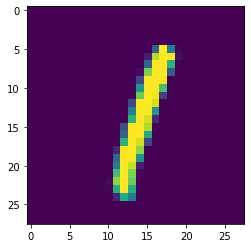

In [8]:
#Create a loader
mnist = datasets.MNIST(root='../data', train=False, download=False, transform=transforms.ToTensor())
#You can access any sample digit from the MNIST dataset using simple indexing mnist[idx]. This returns the digit and the label. We are only interested in the digit. 
x, _ = mnist[5]
#Convert to numpy
x = x.numpy()[0]
#Visualize
plt.imshow(x)

Let's now encode the image in the form of spikes using rate-encoding. Suppose that each pixel in the image needs to be encoded in a spike train of length 2. The steps to encode are outlined below:
* For each pixel in the image, sample a random number.
* If the pixel intensity is greater than the generated random number, output a spike. 
* Repeat for as many timesteps as you need to encode the image for. 
* Repeat for all pixels

In [206]:
#1. Use the numpy.random.rand function to encode the MNIST image into spikes

r = np.random.rand(28,28,10)
output = np.zeros((28,28,10))
            
for i in range(10):
    output[:,:,i] = np.greater(x,r[:,:,i]).astype(int)



#2. Output the shape of the spike-encoded image using numpy.shape
np.shape(output)


(28, 28, 10)

## 6c. 
Now, we will decode the image back from the spike-based representation. Can you think of a way to get the pixel values back? *Hint: Think aggregate measures on the spike trains for each pixel*

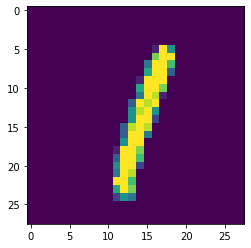

In [208]:
#1. Compute some aggregate measure of spike trains for each pixel to get the image back. Numpy aggregate functions might be useful here
output_arr = output.mean(axis=2)
#2. visualize the reconstructed image
plt.imshow(output_arr)

Is it possible to get the exact image back? Why/Why not?

## Answer 6c.
I believe it isn’t possible to get the exact same image because we are using the random function generator to see if the pixel intensity is greater or not. The probability of generating the exact image is infinitesimal in such a case.

## 6d. 
Can you think of a way to encode the image into spikes in a way such that the decoded image looks as close as possible to the original image? *Hint: Think timesteps*

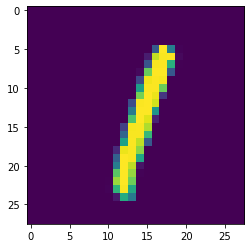

In [250]:
#1. Create a "better" encoding of the image
r = np.random.rand(28,28,200)
output = np.zeros((28,28,200))
            
for i in range(200):
    output[:,:,i] = np.greater(x,r[:,:,i]).astype(int)

#2. Compute and visualize the decoded image
output_arr = output.mean(axis=2)
plt.imshow(output_arr)
  


If each intensity pixel is represented with a value between [0, 255], what would be a reasonable timestep to encode it accurately? What might be a disadvantage of this solution?

## Answer 6d. 
After alot of trial and error, I found approximately 200 to be a reasonable timestep to encode the image accurately to the actual image. The disadvantage would be the time complexity of the model getting affected due to the high timestep value.